In [167]:
import os
import imp
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
import cvxpy as cp
from tqdm import tqdm

from utils import spectral_analysis
from measurements import constrained_linear_measurement_operator
import matrix_sensitivities as mat_sens

In [300]:
sns.set_context("paper")
plt.style.use("bmh")
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath,amssymb}')
matplotlib.rcParams['font.size'] = 7
matplotlib.rcParams['legend.fontsize'] = 7
matplotlib.rcParams['lines.linewidth'] = 2

## Data Management

In [155]:
def make_sens_ts(dvdp,dvdq,n=274):
    """Make timeseries of sensitivity matrices"""
    assert dvdp.shape[0] == dvdq.shape[0]
    m_tot = dvdp.shape[0] #total measurments
    m = int(m_tot/n) #Timeseries interval
    svp,svq = [],[] #timeseries list of svp and svq matrices
    for t in range(m):
        svp.append(dvdp[t*n:(t+1)*n,:])
        svq.append(dvdq[t*n:(t+1)*n,:])
    return {'svp':svp,
            'svq':svq}

def make_deviations(data):
    """Make finite differences"""
    p,q,v = data
    (dp,dq,dv) = [np.diff(x) for x in (p,q,v)]
    dx = np.vstack((dp,dq))
    return (dx,dv)

def make_S_tilde(svp,svq):
    """Make wide S_tilde matrix"""
    return np.vstack((svp.T,svq.T)).T

def make_S_0(S_tilde,pct_obs):
    """Make initial observed matrix"""
    O,_ = constrained_linear_measurement_operator(S_tilde,pct_obs)
    O,S_0 = np.asarray(O),np.multiply(np.asarray(O),S_tilde)
    return O,S_0

# Modeling Complex Power Injections in the IEEE 123-Bus Case using Voltage Sensitivities

## 1. Hourly Varying Demand, Fixed Power Factor
A constant power factor of $\alpha_i = 0.9, i = 1,\dots,n$ is applied to all loads.

In [151]:
path = "/home/sam/github/PowerSensitivities.jl/data/ieee123_ts/HourlyDemand_DB_fixedPF/"
os.chdir(path)
files = "dvdp.pkl","dvdq.pkl",'Pnet.pkl','Qnet.pkl','Volts.pkl'
dvdp,dvdq,p,q,v = [pd.read_pickle(f).values for f in files]
sens = make_sens_ts(dvdp,dvdq)
data = make_deviations((p,q,v))
(dx,dv) = data
svp,svq = sens['svp'],sens['svq']
print(svp[0].shape,svq[0].shape,dx.shape,dv.shape)

(274, 274) (274, 274) (548, 23) (274, 23)


In [152]:
print("Relative pct. error of the 'true' sensitivity matrix: ",np.linalg.norm(dv[:,0] - S_tilde@dx[:,0])/np.linalg.norm(dv[:,0])*100)

Relative pct. error of the 'true' sensitivity matrix:  1.09912479960769


In [89]:
imp.reload(mat_sens)
pf = 0.9*np.ones(S_tilde.shape[0])
K = mat_sens.K(pf)
sqv_impl = [svq_t@K for svq_t in svq]

### Solve the Matrix recovery problem with different levels of precomputed local coefficients

In [163]:
#imp.reload(mat_sens)
#Setup parameters
lamb_,delta_ = cp.Parameter(nonneg=True),cp.Parameter(nonneg=True)
pct_obs_ = [0.1,0.2,0.3,0.4,0.5,0.75] #Different levels of sensitivities already known to the utility
results = []
for i,pct_obs in tqdm(enumerate(pct_obs_)):
    #S_tilde = make_S_tilde(np.mean(svp,axis=0),np.mean(svq,axis=0))
    S_tilde = make_S_tilde(svp[0],svq[0])
    O,S_0 = make_S_0(S_tilde,pct_obs)
    lamb_.value,delta_.value = 1.25e-1,6e-2
    #Solve problem
    S_hat,prob = mat_sens.mat_rec_solution(S_0,dx,dv,lamb=lamb_,o=O,delta=delta_)
    #Store results
    results.append({
        'pct_obs':pct_obs,
        'S_hat':S_hat.value,
        'prob':prob,
        'rel_err':mat_sens.calc_rel_err(S_hat.value,S_tilde)*100
    })

0it [00:00, ?it/s]

                                     CVXPY                                     
                                     v1.2.0                                    
(CVXPY) Apr 07 10:37:13 PM: Your problem has 150152 variables, 1 constraints, and 2 parameters.
(CVXPY) Apr 07 10:37:13 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 07 10:37:13 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 07 10:37:13 PM: Compiling problem (target solver=SCS).
(CVXPY) Apr 07 10:37:13 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> SCS
(CVXPY) Apr 07 10:37:13 PM: Applying reduction Dcp2Cone
(CVXPY) Apr 07 10:37:13 PM: Applying reduction CvxAttr2Constr
(CVXPY

1it [03:19, 199.81s/it]

                                     CVXPY                                     
                                     v1.2.0                                    
(CVXPY) Apr 07 10:40:33 PM: Your problem has 150152 variables, 1 constraints, and 2 parameters.
(CVXPY) Apr 07 10:40:33 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 07 10:40:33 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 07 10:40:33 PM: Compiling problem (target solver=SCS).
(CVXPY) Apr 07 10:40:33 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> SCS
(CVXPY) Apr 07 10:40:33 PM: Applying reduction Dcp2Cone
(CVXPY) Apr 07 10:40:33 PM: Applying reduction CvxAttr2Constr
(CVXPY

2it [06:45, 203.17s/it]

                                     CVXPY                                     
                                     v1.2.0                                    
(CVXPY) Apr 07 10:43:59 PM: Your problem has 150152 variables, 1 constraints, and 2 parameters.
(CVXPY) Apr 07 10:43:59 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 07 10:43:59 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 07 10:43:59 PM: Compiling problem (target solver=SCS).
(CVXPY) Apr 07 10:43:59 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> SCS
(CVXPY) Apr 07 10:43:59 PM: Applying reduction Dcp2Cone
(CVXPY) Apr 07 10:43:59 PM: Applying reduction CvxAttr2Constr
(CVXPY

3it [10:15, 206.41s/it]

                                     CVXPY                                     
                                     v1.2.0                                    
(CVXPY) Apr 07 10:47:29 PM: Your problem has 150152 variables, 1 constraints, and 2 parameters.
(CVXPY) Apr 07 10:47:29 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 07 10:47:29 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 07 10:47:29 PM: Compiling problem (target solver=SCS).
(CVXPY) Apr 07 10:47:29 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> SCS
(CVXPY) Apr 07 10:47:29 PM: Applying reduction Dcp2Cone
(CVXPY) Apr 07 10:47:29 PM: Applying reduction CvxAttr2Constr
(CVXPY

4it [13:37, 204.47s/it]

                                     CVXPY                                     
                                     v1.2.0                                    
(CVXPY) Apr 07 10:50:51 PM: Your problem has 150152 variables, 1 constraints, and 2 parameters.
(CVXPY) Apr 07 10:50:51 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 07 10:50:51 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 07 10:50:51 PM: Compiling problem (target solver=SCS).
(CVXPY) Apr 07 10:50:51 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> SCS
(CVXPY) Apr 07 10:50:51 PM: Applying reduction Dcp2Cone
(CVXPY) Apr 07 10:50:51 PM: Applying reduction CvxAttr2Constr
(CVXPY

5it [16:28, 192.70s/it]

                                     CVXPY                                     
                                     v1.2.0                                    
(CVXPY) Apr 07 10:53:42 PM: Your problem has 150152 variables, 1 constraints, and 2 parameters.
(CVXPY) Apr 07 10:53:42 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 07 10:53:42 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 07 10:53:42 PM: Compiling problem (target solver=SCS).
(CVXPY) Apr 07 10:53:42 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> SCS
(CVXPY) Apr 07 10:53:42 PM: Applying reduction Dcp2Cone
(CVXPY) Apr 07 10:53:42 PM: Applying reduction CvxAttr2Constr
(CVXPY

6it [19:54, 199.14s/it]


In [166]:
mat_sens.calc_rel_err(S_hat.value,S_tilde)*100

1.012055777146652

Text(0.5, 1.0, '75% Observable Sensitivty Matrix (IEEE 123-bus)')

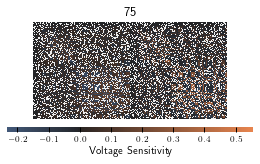

In [164]:
grid_kws = {"height_ratios": (.9, .05), "hspace": .1}
fig,(ax,cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws, figsize=(3.5,3.5/1.61828),constrained_layout=True)
cmap = sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=True)
ax = sns.heatmap(np.asarray(S_0),cmap=cmap,
            center=0,square=True,mask=(np.asarray(S_0)==0),
            xticklabels=False,yticklabels=False,ax=ax,
            cbar_ax=cbar_ax,linewidths=1e-6,
            cbar_kws={"orientation": "horizontal",
                     "label":"Voltage Sensitivity",
                     "pad":0.1},
            rasterized=True)
ax.set_title("{pct_obs:.0f}% Observable Sensitivty Matrix (IEEE 123-bus)".format(pct_obs=pct_obs*100))

/tmp/ipykernel_935133/194154597.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .85, 1])


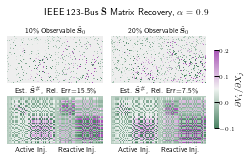

In [356]:
#Subplots
fig,axes = plt.subplots(nrows=2,ncols=2, 
                        figsize=(3.5,3.5/1.61828),
                        #constrained_layout=True,
                        sharex=True, sharey=True)

#Colorbar axis and cmap
cmap = sns.diverging_palette(145, 300, s=60, as_cmap=True)
cbar_ax = fig.add_axes([.85, .2, .02, .5])
cbar_ax.tick_params(labelsize=6,pad=0.5)
cbar_ax.get_yaxis().labelpad = -1
#cbar_ax.set_label(r"$\partial V_i \big/ \partial X_j$",pad=-1)
cbar_kws = {
    'label':r"$\partial V_i \big/ \partial X_j$",
    'fraction':0.05,
    'shrink':15,
    'pad':-10}


#First recovered matrix
pct_obs = results[1]['pct_obs']
rel_err = results[1]['rel_err']
O,S_0 = make_S_0(S_tilde,pct_obs)
#Include colorbar on first heatmap
axes[0,0] = sns.heatmap(np.asarray(S_0),ax=axes[0,0],
                        cmap=cmap,cbar=True,vmin=-0.1,vmax=0.2,
                        cbar_ax=cbar_ax,cbar_kws=cbar_kws,
                        square=True,xticklabels=False,yticklabels=False,
                        mask=(np.asarray(S_0)==0),
                       )
                        
axes[0,0].set_title(r"{pct_obs:.0f}\%".format(pct_obs=pct_obs*100) + r" Observable $\tilde{\mathbf{S}}_0$",fontsize=7,pad=3)
axes[1,0] = sns.heatmap(results[1]['S_hat'],ax=axes[1,0],
                        cmap=cmap,cbar=False,vmin=-0.1,vmax=0.2,
                        square=True,xticklabels=False,yticklabels=False)

axes[1,0].set_title(r"Est. $\tilde{\mathbf{S}}^{\#}$,"+" Rel. Err={rel_err:.1f}\%".format(rel_err=rel_err),fontsize=7,pad=3)
axes[1,0].set_xlabel(r"\ \ \ Active Inj. \quad Reactive Inj.",fontsize=7)

#Second recovered matrix
pct_obs = results[2]['pct_obs']
rel_err = results[2]['rel_err']
O,S_0 = make_S_0(S_tilde,pct_obs)
axes[0,1] = sns.heatmap(np.asarray(S_0),mask=(np.asarray(S_0)==0),ax=axes[0,1],
                        cmap=cmap,cbar=False,vmin=-0.1,vmax=0.2,
                        square=True,xticklabels=False,yticklabels=False)
axes[0,1].set_title(r"{pct_obs:.0f}\%".format(pct_obs=pct_obs*100) + r" Observable $\tilde{\mathbf{S}}_0$",fontsize=7,pad=3)
axes[1,1] = sns.heatmap(results[2]['S_hat'],ax=axes[1,1],
                        cmap=cmap,cbar=False,vmin=-0.1,vmax=0.2,
                        square=True,xticklabels=False,yticklabels=False)
axes[1,1].set_title(r"Est. $\tilde{\mathbf{S}}^{\#}$,"+" Rel. Err={rel_err:.1f}\%".format(rel_err=rel_err),fontsize=7,pad=3)
axes[1,1].set_xlabel(r"\ \ \ Active Inj. \quad  Reactive Inj.",fontsize=7)

#Figure-level formatting
plt.suptitle(r"IEEE 123-Bus $\tilde{\mathbf{S}}$ Matrix Recovery, $\alpha=0.9$",fontsize=9)
fig.tight_layout(rect=[0, 0, .85, 1])
plt.savefig("/home/sam/github/PowerSensitivities.jl/figures/spring_22/IEE123_recovery_multi_lamb.125_delta.006.png",dpi=400)

### Compute the relative error time series (S matrix and voltage perturbations) for each observability level

In [172]:
import utils
for S_result in results:
    pct_obs = S_result["pct_obs"]
    S_hat = S_result["S_hat"]
    v_rel_err,  S_rel_err = [],[]
    for t,(dv_t,dx_t) in enumerate(zip(dv.T,dx.T)):
        hat_dv_t = S_hat@dx_t
        S_tilde = make_S_tilde(svp[t],svq[t])
        S_rel_err.append(mat_sens.calc_rel_err(S_hat,S_tilde)*100)
        v_rel_err.append(utils.calc_vector_rel_err(v_est=hat_dv_t,v_true=dv_t)*100)
    S_result["S_rel_err"] = S_rel_err
    S_result["v_rel_err"] = v_rel_err

### Plot the relative error time series

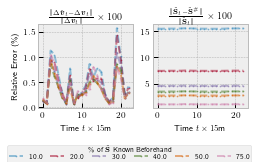

In [310]:
fig,axes = plt.subplots(ncols=2,figsize=(3.5,3.5/1.61828),
                        #constrained_layout=True,
                        sharex=True,sharey=False)
for S_result in results:
    pct_obs = S_result['pct_obs']
    if(pct_obs==0.01):
        continue
    v_rel_err,S_rel_err = S_result['v_rel_err'],S_result['S_rel_err']
    #Voltage relative error
    axes[0].plot(v_rel_err,'--o',label=str(pct_obs*100),alpha=0.5,markersize=0.8)
    #Sensitivity Matrix Relative Error
    axes[1].plot(S_rel_err,'--o',#label=str(pct_obs*100),
                 alpha=0.5,markersize=0.8)
    
#Voltage timeseries plot formatting
axes[0].set_title(r"$\frac{\| \Delta \hat{\boldsymbol{v}}_t - \Delta \boldsymbol{v}_t\|}{\| \Delta \boldsymbol{v}_t \|} \times 100$")
axes[0].set_xlabel(r"Time $t \times 15$m")
axes[0].set_ylabel("Relative Error (\%)")

#S matrix plot formatting
axes[1].set_title(r" $\frac{ \| \tilde{\mathbf{S}}_t - \tilde{\mathbf{S}}^{\#} \|}{\| \tilde{\mathbf{S}}_t \|} \times 100 $")
axes[1].set_xlabel(r"Time $t \times 15$m")

#Legend
fig.legend(fancybox=True,
           ncol=6,borderpad=0.25,labelspacing=1e-3,columnspacing=1.25,
           loc='lower center',borderaxespad=0.01,
           title=r"\% of $\tilde{\mathbf{S}}$ Known Beforehand",
           fontsize=7,title_fontsize=7)
plt.tight_layout()
plt.subplots_adjust(bottom=0.3)
plt.savefig("/home/sam/github/PowerSensitivities.jl/figures/spring_22/rel_errs_ieee123.png",dpi=400)

In [108]:
S_rel_err[0]

7.616903027819162

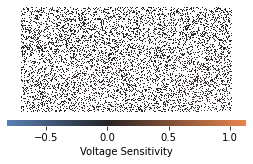

In [374]:
grid_kws = {"height_ratios": (.9, .05), "hspace": .1}
fig,(ax,cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws, figsize=(3.5,3.5/1.61828),constrained_layout=True)
cmap = sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=True)
ax = sns.heatmap(np.asarray(S_hat),cmap=cmap,
            center=0,square=True,mask=(np.asarray(S_hat)==0),
            xticklabels=False,yticklabels=False,ax=ax,
            cbar_ax=cbar_ax,linewidths=1e-6,
            cbar_kws={"orientation": "horizontal",
                     "label":"Voltage Sensitivity",
                     "pad":0.1},
            rasterized=True)

### Plot the Spectral Analysis for the IEEE 123 Test Feeder

In [100]:
cum_sigma,normed_sigma = spectral_analysis(S_tilde)

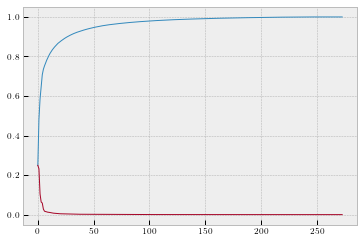

In [102]:
plt.plot(cum_sigma)
plt.plot(normed_sigma)

## 2. Synthetic demands, fixed power factor 

In [ ]:
path = "/home/sam/github/PowerSensitivities.jl/data/ieee123_ts/Synthetic_DB_fixedPF/"
os.chdir(path)
files = "dvdp.pkl","dvdq.pkl",'Pnet.pkl','Qnet.pkl','Volts.pkl'
dvdp,dvdq,p,q,v = [pd.read_pickle(f).values for f in files]
svp,svq = make_sens_ts(dvdp,dvdq)

## 3. Synthetic demands, varying power factor

In [ ]:
path = "/home/sam/github/PowerSensitivities.jl/data/ieee123_ts/Synthetic_DB/"
os.chdir(path)
files = "dvdp.pkl","dvdq.pkl",'Pnet.pkl','Qnet.pkl','Volts.pkl'
dvdp,dvdq,p,q,v = [pd.read_pickle(f).values for f in files]
svp,svq = make_sens_ts(dvdp,dvdq)